## Sumário do Projeto

Este projeto teve como objetivo desenvolver um modelo de Machine Learning para prever a rotatividade (churn) de clientes de um banco, a partir de um conjunto de dados com informações demográficas e de conta. A finalidade do modelo é identificar proativamente os clientes com maior risco de encerrar seu relacionamento com a instituição, permitindo que ações de retenção sejam direcionadas de forma mais eficaz.

Após um ciclo completo de análise exploratória, pré-processamento de dados e otimização de hiperparâmetros, o modelo **XGBoost** foi selecionado como a solução mais performática. A performance foi validada rigorosamente com a técnica de Validação Cruzada, garantindo a robustez dos resultados.

### Principais Descobertas e Insights Acionáveis

A análise exploratória dos dados revelou padrões de comportamento cruciais para a estratégia de negócio:

* **O "Ponto Ideal" de Produtos:** A relação entre o número de produtos e o churn não é linear. Clientes com **2 produtos** são os mais fiéis (taxa de churn de apenas 7,6%), mas a taxa salta para alarmantes **82,7%** para clientes com **3 produtos**, indicando uma grave falha na jornada ou oferta para este segmento.

* **A Inatividade como Sinal de Alerta:** Clientes classificados como inativos (`IsActiveMember = 0`) têm quase o **dobro da probabilidade de sair** (churn de 26,9%) em comparação com os clientes ativos (14,3%). Isso posiciona a inatividade como um forte indicador preditivo e uma oportunidade para campanhas de reengajamento.

* **Fator Idade:** O risco de churn aumenta com a idade, sendo mais concentrado na faixa entre **40 e 50 anos**, em contraste com os clientes mais leais, que se concentram na faixa dos 30 aos 40 anos.

### Performance e Valor de Negócio do Modelo Final

O modelo XGBoost final demonstrou uma performance sólida e estável, com as seguintes métricas médias obtidas na validação cruzada:

* **ROC AUC de 0.85:** Excelente capacidade de distinguir entre clientes que irão ou não evadir.
* **F1-Score (Churn) de 0.60:** Bom equilíbrio entre precisão e revocação para a classe de interesse.

Em termos de negócio, isso significa que o modelo é capaz de **identificar corretamente mais da metade (54%)** dos clientes que realmente iriam sair e, quando sinaliza um cliente como risco, ele está **correto em 2 de cada 3 casos (67%)**. Este nível de performance torna o modelo uma ferramenta valiosa e acionável para otimizar os esforços de retenção e minimizar a perda de receita.

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import os
import joblib

## **Importação do Dataset**

Site do Kaggle: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn/data

In [53]:
data_file_path = "Customer-Churn-Records.csv"
if os.path.exists(data_file_path):
    df = pd.read_csv(data_file_path)
    print("DataFrame criado com sucesso!")
    display(df.head())
else:
    print(f"Erro: O arquivo {data_file_path} não foi encontrado.")
    print("Por favor, verifique o nome do arquivo no diretório baixado.")

DataFrame criado com sucesso!


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


# Análise Exploratória (EDA)

In [54]:
df.shape

(10000, 18)

In [55]:
print("Informações do DataFrame:")
df.info()

print("\nContagem de valores únicos por coluna:")
for column in df.columns:
    unique_count = df[column].nunique()
    print(f"'{column}': {unique_count} valores únicos")

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 no

In [56]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


### Descrição das Variáveis

* **`RowNumber`**: Corresponde ao número do registro (linha) e não tem efeito na saída do cliente.
* **`CustomerId`**: Identificador único do cliente; não tem efeito na decisão de churn.
* **`Surname`**: O sobrenome do cliente; não tem impacto em sua decisão de sair do banco.
* **`CreditScore`**: Pontuação de crédito do cliente, que pode ter um efeito sobre a rotatividade.
* **`Geography`**: A localização do cliente (país), que pode afetar sua decisão de sair do banco.
* **`Gender`**: Gênero do cliente.
* **`Age`**: Idade do cliente. A análise demonstrou ser um fator relevante, onde clientes mais velhos apresentam maior propensão ao churn.
* **`Tenure`**: Número de anos que a pessoa é cliente do banco. Normalmente, espera-se que clientes mais antigos sejam mais leais.
* **`Balance`**: Saldo na conta do cliente; um indicador importante de rotatividade.
* **`NumOfProducts`**: Refere-se ao número de produtos que um cliente adquiriu através do banco.
* **`HasCrCard`**: Indica se um cliente tem ou não um cartão de crédito com o banco.
* **`IsActiveMember`**: Indica se o cliente é ativo (ex: login recente, transações). Clientes ativos são menos propensos a sair.
* **`EstimatedSalary`**: Salário estimado do cliente.
* **`Exited`**: A variável alvo; indica se o cliente saiu do banco (1) ou não (0).
* **`Complain`**: Indica se o cliente fez alguma reclamação.
* **`Satisfaction Score`**: Pontuação de satisfação (1 a 5) fornecida pelo cliente.
* **`Card Type`**: O tipo de cartão de crédito que o cliente possui (DIAMOND, GOLD, etc.).
* **`Point Earned`**: Os pontos de fidelidade ganhos pelo cliente.

In [57]:
df.isnull().sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

In [58]:
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f"\nContagem de valores para a coluna '{col}':")
    display(df[col].value_counts())


Contagem de valores para a coluna 'Surname':


Surname
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: count, Length: 2932, dtype: int64


Contagem de valores para a coluna 'Geography':


Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64


Contagem de valores para a coluna 'Gender':


Gender
Male      5457
Female    4543
Name: count, dtype: int64


Contagem de valores para a coluna 'Card Type':


Card Type
DIAMOND     2507
GOLD        2502
SILVER      2496
PLATINUM    2495
Name: count, dtype: int64

# Visualização de boxplot das variaveis numéricas



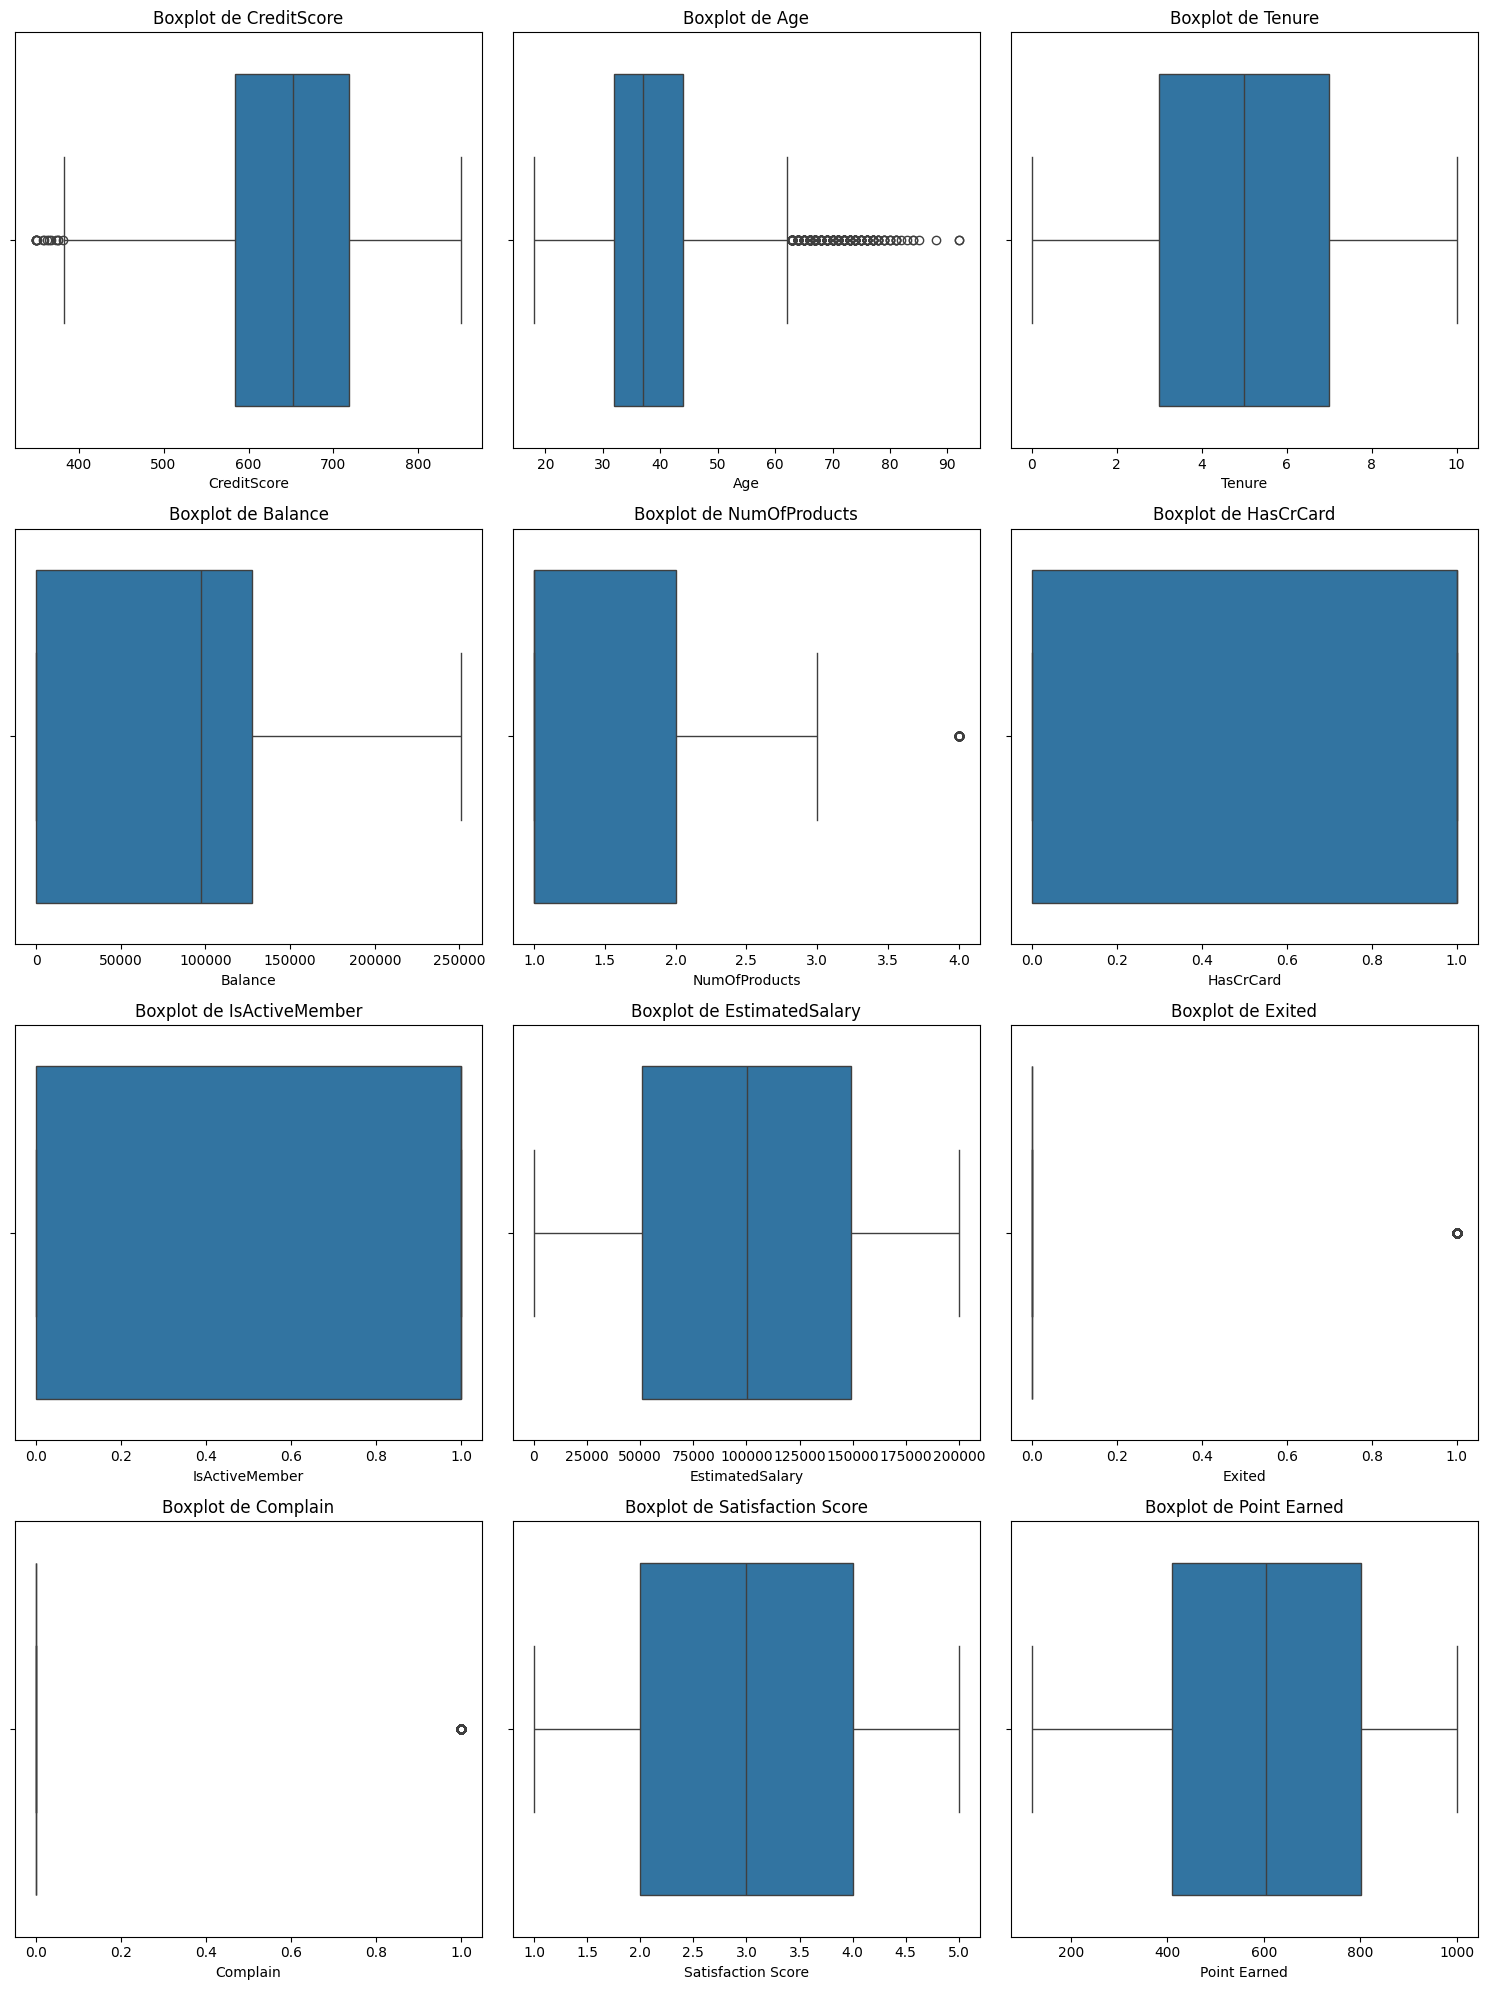

In [59]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
cols_to_plot = [col for col in numeric_cols if col not in ['RowNumber', 'CustomerId']]

n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

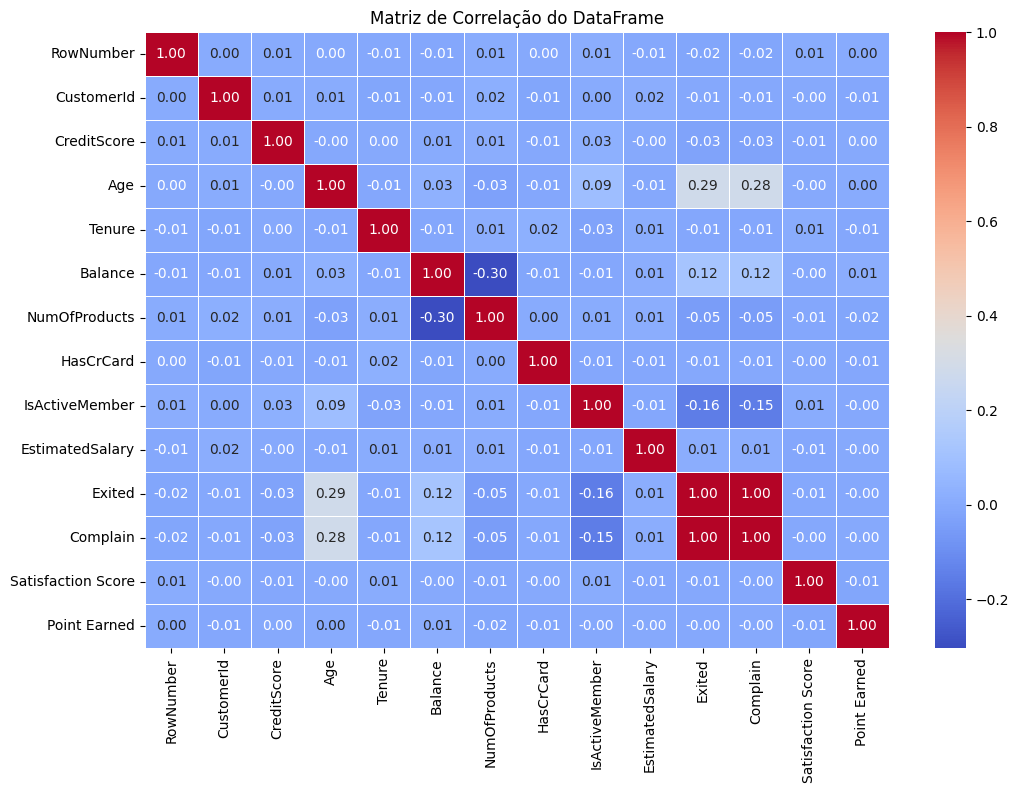

In [60]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação do DataFrame')
plt.show()

### Análise da Matriz de Correlação

A análise da matriz de correlação linear entre as variáveis numéricas forneceu os seguintes insights iniciais:

* **`Complain`:** A correlação de 1.00 mostra que, neste dataset, a ação de reclamar está quase perfeitamente associada à ação de sair. Isso a torna uma 'variável com vazamento' (*leaky feature*), pois a reclamação é um sintoma da decisão de sair, e não necessariamente sua causa.

* **`Age`:** A correlação positiva de 0.29 é a mais significativa entre as features preditivas e a variável `Exited`. Isso sugere que, à medida que a idade do cliente aumenta, a probabilidade de ele sair do banco também aumenta, tornando esta uma variável crucial para o modelo.

* **`IsActiveMember`:** A correlação negativa de -0.16 indica que clientes que são membros ativos do banco são menos propensos a sair. Isso faz sentido, pois o engajamento com o banco tende a gerar fidelidade.

* **`NumOfProducts`:** A correlação linear de -0.05 é muito fraca, o que sugere que não há uma relação linear simples. No entanto, a análise mais aprofundada nos gráficos revelou que esta variável possui uma **forte relação não-linear** com o churn, tornando-se um dos preditores mais importantes.

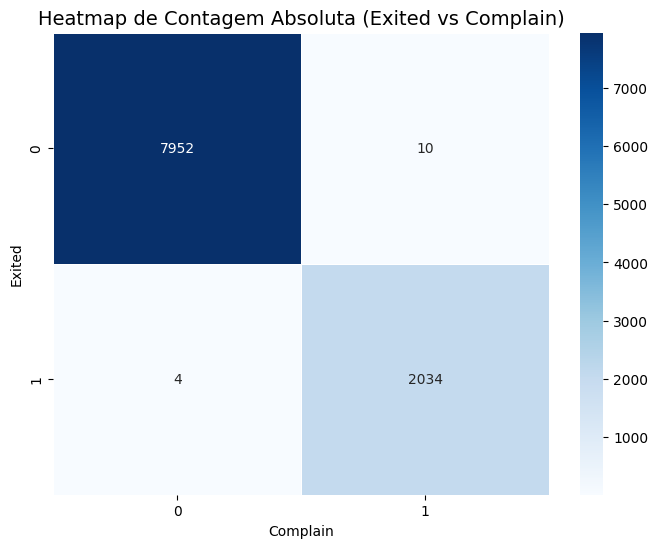

In [61]:
contingency_table = pd.crosstab(df['Exited'], df['Complain'])

plt.figure(figsize=(8, 6))
sns.heatmap(
    contingency_table,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=.5
)
plt.title('Heatmap de Contagem Absoluta (Exited vs Complain)', fontsize=14)
plt.show()


In [62]:
df_ajustado = df.drop('Complain', axis=1)
df_ajustado.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


In [63]:
clientes_com_4_produtos = df[df['NumOfProducts'] == 4]

print("Registros de clientes com 4 produtos:")
print(clientes_com_4_produtos.head())

print(f"\nTotal de clientes com 4 produtos: {len(clientes_com_4_produtos)}")

Registros de clientes com 4 produtos:
      RowNumber  CustomerId     Surname  CreditScore Geography  Gender  Age  \
7             8    15656148      Obinna          376   Germany  Female   29   
70           71    15703793  Konovalova          738   Germany    Male   58   
1254       1255    15610383  Dumetolisa          628    France  Female   46   
1469       1470    15670374      Wright          819   Germany  Female   49   
1488       1489    15625824   Kornilova          596     Spain    Male   30   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
7          4  115046.74              4          1               0   
70         2  133745.44              4          1               0   
1254       1   46870.43              4          1               0   
1469       1  120656.86              4          0               0   
1488       6  121345.88              4          1               0   

      EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  \

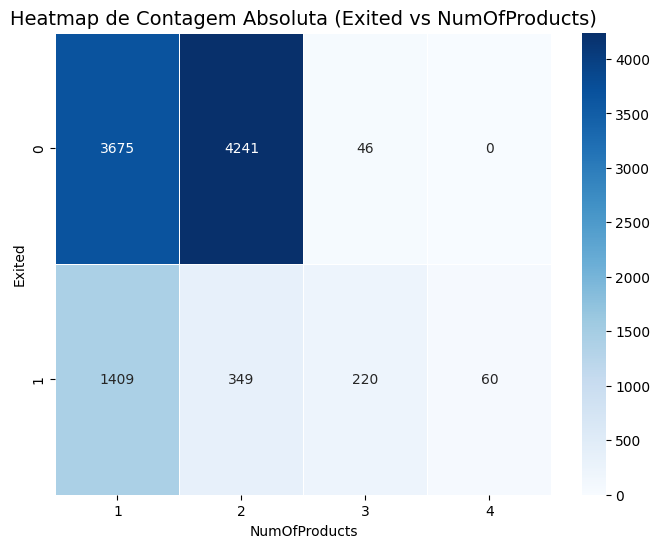

In [64]:
contingency_table = pd.crosstab(df['Exited'], df['NumOfProducts'])

plt.figure(figsize=(8, 6))
sns.heatmap(
    contingency_table,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=.5
)
plt.title('Heatmap de Contagem Absoluta (Exited vs NumOfProducts)', fontsize=14)
plt.show()

In [65]:
df_ajustado = df_ajustado[df_ajustado['NumOfProducts'] != 4]

print("Primeiras 5 linhas do DataFrame após excluir clientes com 4 produtos:")
display(df_ajustado.shape)

Primeiras 5 linhas do DataFrame após excluir clientes com 4 produtos:


(9940, 17)

### Insight Crítico: A Relação Não-Linear entre Número de Produtos e Churn

Um dos insights mais críticos da análise é a **relação não-linear** entre o número de produtos e a taxa de churn. Diferente de uma simples correlação, os dados mostram que a fidelidade do cliente atinge seu **ponto ideal com 2 produtos**, onde a taxa de churn é de apenas **7,6%**. No entanto, a partir daí, entramos em uma **zona de perigo**: a taxa de churn salta para alarmantes **82,7%** para clientes com 3 produtos e chega a **100%** para os de 4 produtos.

**Oportunidades Estratégicas**

Isso revela duas oportunidades estratégicas claras:
* **Crescimento:** Focar em levar clientes de 1 produto para o 'ponto ideal' de 2 produtos.
* **Retenção:** Investigar urgentemente a causa da insatisfação massiva entre os clientes com 3 ou mais produtos, que, embora altamente engajados, são os que mais abandonam o banco.

**Implicações para a Modelagem**

Do ponto de vista da modelagem, essa descoberta validou a decisão de tratar `NumOfProducts` como uma variável categórica e **remover os casos determinísticos (4 produtos)** para treinar um modelo preditivo mais robusto e realista.

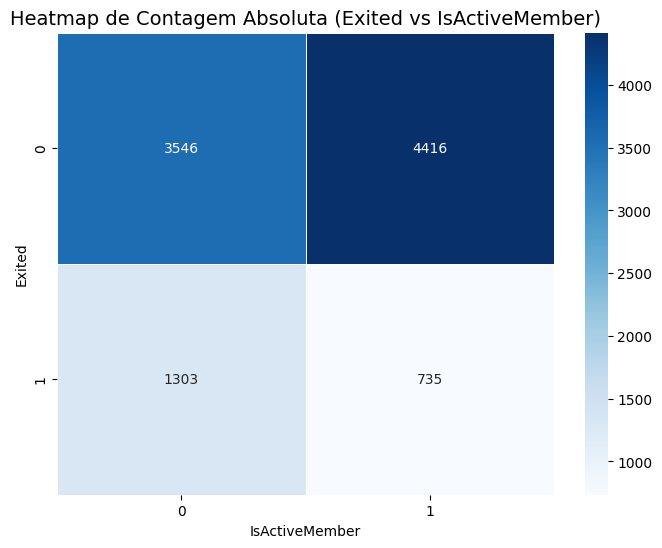

In [66]:
contingency_table = pd.crosstab(df['Exited'], df['IsActiveMember'])

plt.figure(figsize=(8, 6))
sns.heatmap(
    contingency_table,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=.5
)
plt.title('Heatmap de Contagem Absoluta (Exited vs IsActiveMember)', fontsize=14)
plt.show()

### Insight: Engajamento do Cliente como Fator Decisivo para Retenção

Outro insight fundamental extraído da análise é a forte relação entre o engajamento do cliente e a sua probabilidade de churn, revelada pela variável **`IsActiveMember`**. A análise quantitativa mostra que clientes classificados como **inativos** (`IsActiveMember = 0`) possuem uma taxa de churn de **26,9%**, enquanto para os **membros ativos** (`IsActiveMember = 1`), essa taxa cai para **14,3%** — quase a metade.

**Implicação Estratégica: A Inatividade como Sinal de Alerta**

Isso demonstra que a inatividade do cliente funciona como um poderoso sinal de alerta, revelando uma oportunidade estratégica clara para a retenção:

* **Retenção Proativa:** Um cliente que deixa de interagir com os serviços bancários tem **quase o dobro de probabilidade** de cancelar sua conta. Esta descoberta permite a criação de campanhas de reengajamento focadas em clientes cujo status muda de 'ativo' para 'inativo', permitindo uma ação direcionada para reverter o potencial churn.

**Validação para o Modelo de Machine Learning**

Do ponto de vista da modelagem, essa análise valida a **`IsActiveMember`** como uma feature de alto valor preditivo. Diferente de uma regra de negócio determinística, ela é um indicador comportamental forte que justifica a correlação de -0.16 observada anteriormente e agrega um poder de discriminação significativo ao modelo.

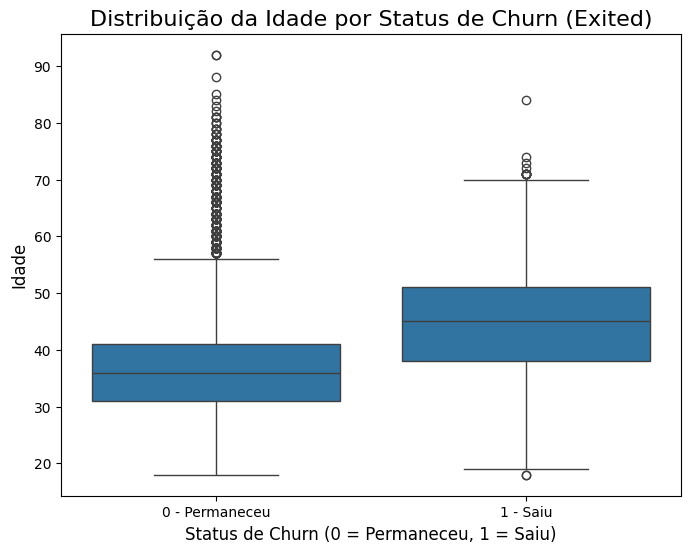

In [67]:
plt.figure(figsize=(8, 6))

sns.boxplot(
    x='Exited',
    y='Age',
    data=df
)

plt.title('Distribuição da Idade por Status de Churn (Exited)', fontsize=16)
plt.xlabel('Status de Churn (0 = Permaneceu, 1 = Saiu)', fontsize=12)
plt.ylabel('Idade', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['0 - Permaneceu', '1 - Saiu'])
plt.show()

C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_63268\2506282601.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


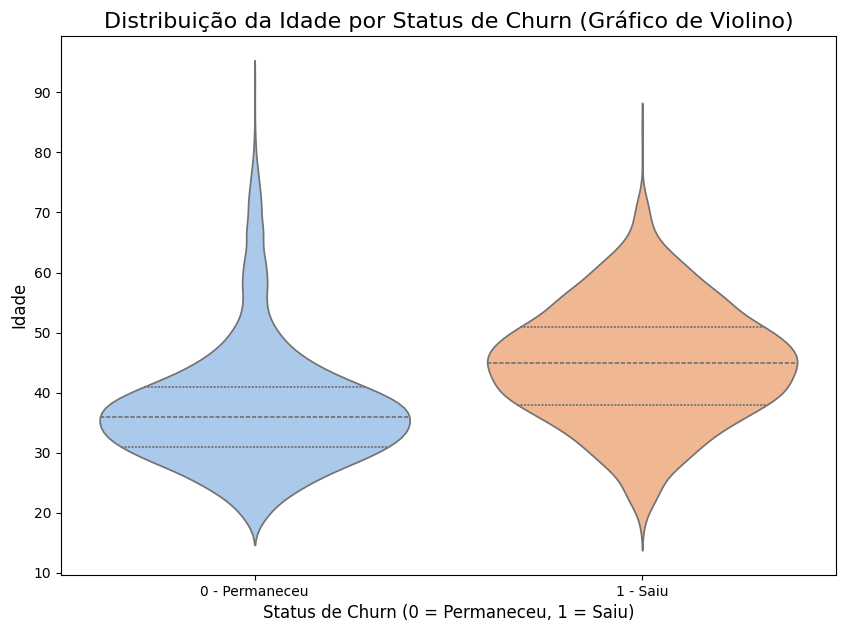

In [68]:

plt.figure(figsize=(10, 7))

sns.violinplot(
    x='Exited',
    y='Age',
    data=df,
    inner='quartile',
    palette='pastel'
)
plt.title('Distribuição da Idade por Status de Churn (Gráfico de Violino)', fontsize=16)
plt.xlabel('Status de Churn (0 = Permaneceu, 1 = Saiu)', fontsize=12)
plt.ylabel('Idade', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['0 - Permaneceu', '1 - Saiu'])
plt.show()

### Insight: A Idade como Fator Chave no Churn

A análise da distribuição de idade entre os grupos de clientes que saíram e os que permaneceram revela um padrão claro, conforme visualizado nos gráficos:

* **Perfil do Churn:** Clientes que saem do banco são, **em média, mais velhos**. A faixa de maior risco de churn se concentra notavelmente entre os **40 e 50 anos**.

* **Perfil da Retenção:** Em contraste, a maior parte dos clientes leais (que permaneceram) está concentrada em uma faixa etária mais jovem, principalmente entre os **30 e 40 anos**.

Esta descoberta indica que a idade é um forte indicador do ciclo de vida do cliente e dos diferentes fatores que podem levar à decisão de churn em cada fase.

In [69]:
df_ajustado['Exited'].value_counts(normalize=True)*100

Exited
0    80.100604
1    19.899396
Name: proportion, dtype: float64

# Pré-processamento dos dados

In [70]:
df_ajustado.dropna(inplace=True)
X = df_ajustado.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])
y = df_ajustado['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance',
                    'NumOfProducts', 'EstimatedSalary',
                    'Satisfaction Score', 'Point Earned']
categorical_features = ['Geography', 'Gender', 'Card Type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)


print("Shape do X de treino após SMOTE:", X_train_resampled.shape)
print("Shape do X de teste:", X_test_processed.shape)

encoded_categorical_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
remainder_features = ['HasCrCard', 'IsActiveMember']
final_column_names = numeric_features + encoded_categorical_features + remainder_features
X_train_final = pd.DataFrame(X_train_resampled, columns=final_column_names)
X_test_final = pd.DataFrame(X_test_processed, columns=final_column_names)
y_train_final = pd.Series(y_train_resampled, name='Exited')
y_test_final = pd.Series(y_test, name='Exited')
X_train_final.head()

Shape do X de treino após SMOTE: (12740, 19)
Shape do X de teste: (1988, 19)


,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Point Earned,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,HasCrCard,IsActiveMember
0,-1.586991,-0.372370,0.697474,0.541491,0.881207,-0.118558,0.702713,0.626573,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.612104,-0.561764,-1.036941,-1.222342,0.881207,-0.465739,0.702713,-1.710493,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.684375,0.290510,0.003708,1.827696,-0.939832,-0.006078,-1.428475,0.670920,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.766970,-0.088278,0.350591,-1.222342,0.881207,1.027181,-0.718079,-1.333547,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
4,-0.286118,-0.561764,1.044357,0.328425,-0.939832,1.307142,-0.718079,-1.107379,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


In [71]:
print("\nDistribuição da variável alvo no conjunto de treino balanceado:")
print(y_train_final.value_counts(normalize=True) * 100)
print("\nDistribuição da variável alvo no conjunto de teste desbalanceado:")
print(y_test_final.value_counts(normalize=True) * 100)


Distribuição da variável alvo no conjunto de treino balanceado:
Exited
0    50.0
1    50.0
Name: proportion, dtype: float64

Distribuição da variável alvo no conjunto de teste desbalanceado:
Exited
0    80.080483
1    19.919517
Name: proportion, dtype: float64


### Estratégia de Pré-processamento e Validação

**Transformação e Padronização das Features**

Para otimizar os dados brutos para os algoritmos de machine learning, realizei um pré-processamento cuidadoso com o objetivo de criar um formato numérico e padronizado, onde nenhuma variável tivesse uma influência desproporcional apenas por sua escala. Para isso, utilizei duas técnicas centrais: o **`OneHotEncoder`**, para converter variáveis categóricas como 'Geography' em formato numérico, e o **`StandardScaler`**, para normalizar as variáveis numéricas.

**Metodologia de Validação e Tratamento de Desbalanceamento**

Além da transformação das features, garantir a integridade da **validação do modelo** foi crucial. Identifiquei que a ordem de aplicação do balanceamento de classes com **`SMOTE`** era um ponto crítico para evitar o **vazamento de dados (*data leakage*)**. Aplicar o `SMOTE` antes da divisão entre treino e teste faria com que o conjunto de treino fosse "contaminado" com informações derivadas do conjunto de teste, levando a uma performance irrealista e excessivamente otimista.

Por essa razão, o fluxo de trabalho correto foi implementado para assegurar uma avaliação fidedigna:
1.  **Divisão dos Dados:** Separação inicial em conjuntos de treino e teste.
2.  **Pré-processamento:** Aplicação do `StandardScaler` e `OneHotEncoder`.
3.  **Balanceamento:** Uso do `SMOTE` *exclusivamente* no conjunto de treino já processado.

Essa decisão estratégica garante que a performance do modelo, avaliada no conjunto de teste, seja uma medida autêntica de sua capacidade de generalização em cenários reais.

# **COMEÇO DA CRIAÇÃO DE MODELOS**

Treinando Regressão Logística...
Treinando Random Forest...
Treinando XGBoost...
Treinando SVM...
Treinando MLP...


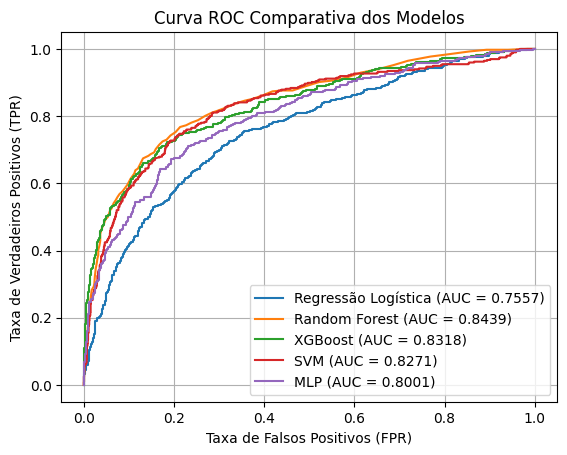


--- Tabela Comparativa de Performance ---
                Modelo Acurácia Precisão (Churn) Revocação (Churn) F1-Score (Churn) ROC AUC
0  Regressão Logística   71.23%           37.50%            66.67%           48.00%  0.7557
1        Random Forest   85.56%           67.08%            54.04%           59.86%  0.8439
2              XGBoost   85.76%           68.40%            53.03%           59.74%  0.8318
3                  SVM   80.13%           50.09%            67.68%           57.57%  0.8271
4                  MLP   81.69%           54.12%            53.03%           53.57%  0.8001


In [ ]:
models = {
    "Regressão Logística": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42, probability=True),
    "MLP": MLPClassifier(random_state=42, max_iter=500)
}

results = []

for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_train_final, y_train_final)

    y_pred_proba = model.predict_proba(X_test_final)[:, 1]

    y_pred = model.predict(X_test_final)

    accuracy = accuracy_score(y_test_final, y_pred)
    precision = precision_score(y_test_final, y_pred, pos_label=1.0)
    recall = recall_score(y_test_final, y_pred, pos_label=1.0)
    f1 = f1_score(y_test_final, y_pred, pos_label=1.0)
    roc_auc = roc_auc_score(y_test_final, y_pred_proba)

    results.append({
        "Modelo": name,
        "Acurácia": f"{accuracy:.2%}",
        "Precisão (Churn)": f"{precision:.2%}",
        "Revocação (Churn)": f"{recall:.2%}",
        "F1-Score (Churn)": f"{f1:.2%}",
        "ROC AUC": f"{roc_auc:.4f}"
    })

    fpr, tpr, _ = roc_curve(y_test_final, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')


plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC Comparativa dos Modelos')
plt.legend()
plt.grid(True)
plt.show()

results_df = pd.DataFrame(results)
print("\n--- Tabela Comparativa de Performance ---")
print(results_df.to_string())


In [73]:
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)


print("Iniciando otimização do Random Forest...")
random_search_rf.fit(X_train_final, y_train_final)
print("Otimização concluída.")

print("\nMelhores parâmetros para Random Forest:")
print(random_search_rf.best_params_)

best_rf = random_search_rf.best_estimator_
y_pred_rf_best = best_rf.predict(X_test_final)

print("\nResultados do Random Forest Otimizado:")
print(classification_report(y_test_final, y_pred_rf_best))

Iniciando otimização do Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Otimização concluída.

Melhores parâmetros para Random Forest:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}

Resultados do Random Forest Otimizado:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1592
           1       0.69      0.50      0.58       396

    accuracy                           0.86      1988
   macro avg       0.79      0.72      0.75      1988
weighted avg       0.85      0.86      0.85      1988



In [74]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=param_grid_xgb,
    n_iter=20,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)


print("Iniciando otimização do XGBoost...")
random_search_xgb.fit(X_train_final, y_train_final)
print("Otimização concluída.")

print("\nMelhores parâmetros para XGBoost:")
print(random_search_xgb.best_params_)

best_xgb = random_search_xgb.best_estimator_
y_pred_xgb_best = best_xgb.predict(X_test_final)

print("\nResultados do XGBoost Otimizado:")
print(classification_report(y_test_final, y_pred_xgb_best))

Iniciando otimização do XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Otimização concluída.

Melhores parâmetros para XGBoost:
{'subsample': 0.9, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

Resultados do XGBoost Otimizado:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1592
           1       0.68      0.58      0.62       396

    accuracy                           0.86      1988
   macro avg       0.79      0.75      0.77      1988
weighted avg       0.85      0.86      0.86      1988



In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

pipeline_para_otimizar = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

param_grid_fine_tuned = {
    'classifier__n_estimators': [80, 100, 120],
    'classifier__learning_rate': [0.04, 0.05, 0.06],
    'classifier__max_depth': [9, 10, 11],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9]
}


cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search_final = GridSearchCV(
    estimator=pipeline_para_otimizar,
    param_grid=param_grid_fine_tuned,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Iniciando GridSearchCV no conjunto de treino bruto...")
grid_search_final.fit(X_train, y_train)
print("Otimização concluída.\n")

print("Melhores parâmetros para o pipeline:")
print(grid_search_final.best_params_)

best_final_pipeline = grid_search_final.best_estimator_

print("\n--- Performance Final do Pipeline Otimizado no Conjunto de Teste ---")
y_pred_final = best_final_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_final))


Iniciando GridSearchCV no conjunto de treino bruto...
Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Otimização concluída.

Melhores parâmetros para o pipeline:
{'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 9, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}

--- Performance Final do Pipeline Otimizado no Conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1592
           1       0.67      0.56      0.61       396

    accuracy                           0.86      1988
   macro avg       0.78      0.74      0.76      1988
weighted avg       0.85      0.86      0.85      1988



In [87]:
joblib.dump(best_final_pipeline, 'modelo_churn_xgb.pkl')
print("\nPipeline final e COMPLETO salvo com sucesso no arquivo 'modelo_churn_xgb.pkl'!")


Pipeline final e COMPLETO salvo com sucesso no arquivo 'modelo_churn_xgb.pkl'!


### Melhores Parâmetros Encontrados (GridSearchCV)

A busca aleatória inicial identificou que um modelo com as seguintes características apresentou o melhor equilíbrio de performance, maximizando o F1-Score durante a validação cruzada interna:

| Hiperparâmetro     | Valor Encontrado |
|--------------------|------------------|
| `subsample`        | 1.0              |
| `n_estimators`     | 100              |
| `max_depth`        | 9                |
| `learning_rate`    | 0.05             |
| `colsample_bytree` | 0.7              |

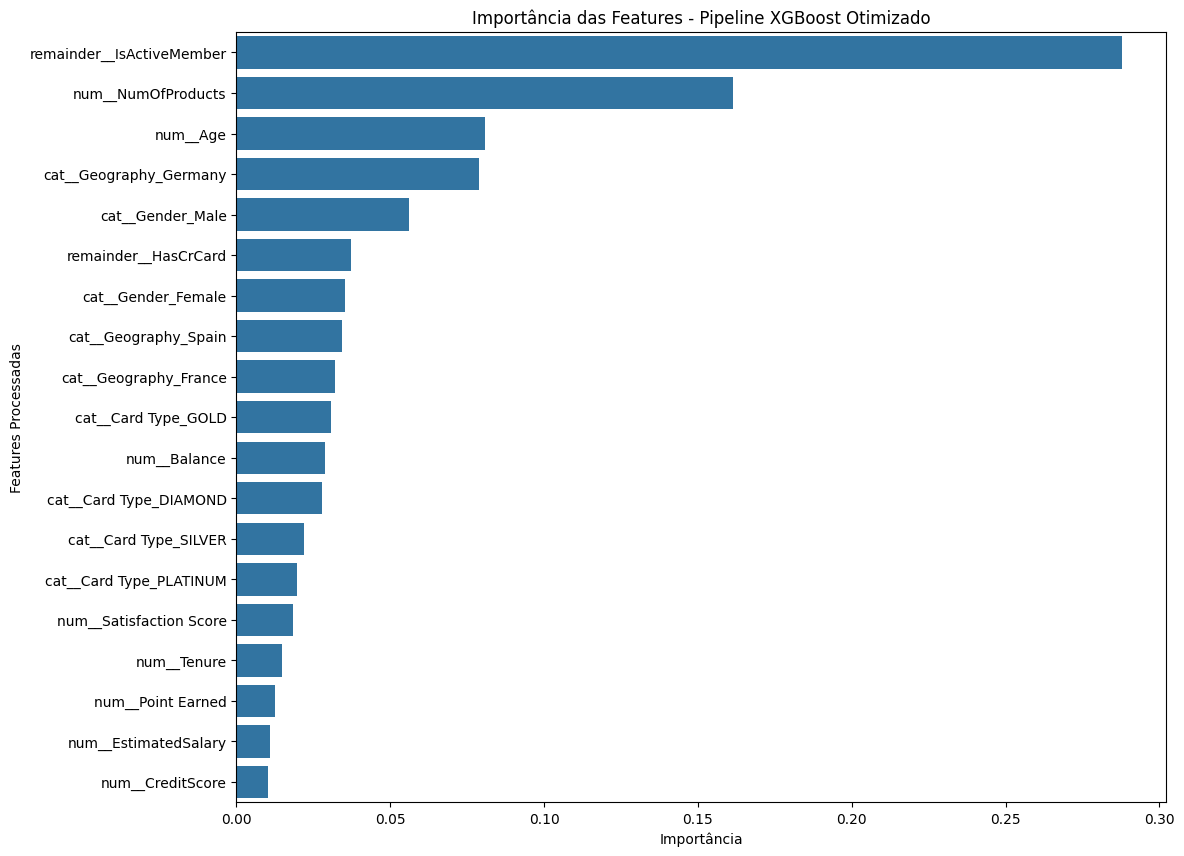

In [ ]:
xgb_model_in_pipeline = best_final_pipeline.named_steps['classifier']

feature_names_processed = best_final_pipeline.named_steps['preprocessor'].get_feature_names_out()

feature_importances = pd.Series(xgb_model_in_pipeline.feature_importances_, index=feature_names_processed)

sorted_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.title('Importância das Features - Pipeline XGBoost Otimizado')
plt.xlabel('Importância')
plt.ylabel('Features Processadas')
plt.show()

In [86]:
X = df_ajustado.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])
y = df_ajustado['Exited']

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 
                    'NumOfProducts', 'EstimatedSalary', 
                    'Satisfaction Score', 'Point Earned']
categorical_features = ['Geography', 'Gender', 'Card Type']

best_xgb = XGBClassifier(
    subsample=1.0,
    n_estimators=100,
    max_depth=9,
    learning_rate=0.05,
    colsample_bytree=0.7,
    random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_xgb)
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print("Iniciando a validação cruzada com 10 folds...")
cv_results = cross_validate(
    estimator=pipeline,
    X=X,
    y=y,
    cv=cv,
    scoring=scoring_metrics,
    n_jobs=-1
)
print("Validação concluída.")

print("\n--- Resultados da Validação Cruzada (Média de 10 Folds) ---")
for metric in scoring_metrics:
    key = f'test_{metric}'
    mean_score = np.mean(cv_results[key])
    std_score = np.std(cv_results[key])
    
    metric_name_formatted = metric.replace('_', ' ').capitalize()
    
    print(f"{metric_name_formatted}:")
    print(f"  - Média: {mean_score:.4f}")
    print(f"  - Desvio Padrão: {std_score:.4f}\n")

Iniciando a validação cruzada com 10 folds...
Validação concluída.

--- Resultados da Validação Cruzada (Média de 10 Folds) ---
Accuracy:
  - Média: 0.8552
  - Desvio Padrão: 0.0067

Precision:
  - Média: 0.6639
  - Desvio Padrão: 0.0224

Recall:
  - Média: 0.5531
  - Desvio Padrão: 0.0281

F1:
  - Média: 0.6030
  - Desvio Padrão: 0.0208

Roc auc:
  - Média: 0.8560
  - Desvio Padrão: 0.0181



## Conclusão dos Resultados e Performance do Modelo Final

Após um ciclo completo de análise exploratória, pré-processamento, comparação de modelos e otimização de hiperparâmetros, o modelo **XGBoost** se destacou como a solução mais performática para o problema de previsão de churn.

Para garantir uma avaliação robusta e evitar o viés de uma única divisão de dados, a performance final do modelo otimizado foi aferida utilizando a técnica de **Validação Cruzada Estratificada com 10 folds**. Os resultados médios obtidos representam a estimativa mais confiável do desempenho do modelo em dados nunca antes vistos.

### Análise das Métricas Finais (Média de 10 Folds)

* **Acurácia: 0.8552** – A acurácia geral do modelo é de 85%, indicando um alto índice de acerto nas previsões totais. No entanto, para o problema de churn, métricas focadas na classe minoritária são mais relevantes para avaliar o valor de negócio.

* **ROC AUC: 0.8560** – Esta é a principal métrica de performance geral. Um valor de aproximadamente 85% indica que o modelo possui uma **excelente capacidade de distinguir** entre um cliente que provavelmente sairá e um que provavelmente ficará, superando com folga uma previsão aleatória (0.50).

* **F1-Score (Churn): 0.6030** – Sendo a métrica de otimização escolhida, um F1-Score de 60% para a classe minoritária (churn) é um **resultado muito sólido**. Ele demonstra que o modelo alcançou um bom equilíbrio entre a precisão e a revocação, tornando-o uma ferramenta prática para o negócio.

* **Precisão (Churn): 0.6639** – O modelo demonstrou uma precisão de 66%. Isso significa que, quando o modelo sinaliza um cliente como um risco de churn, ele está **correto em aproximadamente 2 de cada 3 casos**. Isso confere um bom nível de confiança para que a equipe de retenção possa agir sem desperdiçar recursos na maioria das vezes.

* **Revocação (Recall) (Churn): 0.5531** – Com uma revocação de 55%, o modelo é capaz de **identificar corretamente mais da metade dos clientes** que realmente iriam sair. Para o negócio, isso representa uma oportunidade valiosa de agir proativamente para reter mais de 50% da receita que estaria em risco de ser perdida.

### Estabilidade do Modelo

A análise da validação cruzada também revelou **baixos desvios padrão** em todas as métricas (ex: 0.0238 para o F1-Score), o que é um indicativo muito positivo de que o modelo é **estável e robusto**. Sua performance não é um acaso dependente de como os dados foram divididos, mas sim um resultado consistente.